In [140]:
%pip install yfinance pyspark

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [141]:
# Imports.
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import re
from pyspark.sql import SparkSession
from pyspark.sql.functions import size
from pyspark.ml.fpm import FPGrowth
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [142]:
# Getting our financial data.
tickers = [
    # NVIDIA
    "NVDA",
    
    # Semiconductor Industry
    "AMD", "INTC", "ASML", "MU", "TXN", "AVGO", "QCOM", "LRCX", "AMAT", "KLAC", "ON", "NXPI",
    
    # Tech Giants & Related Companies
    "AAPL", "GOOG", "META", "IBM", "ORCL", "CRM", "ADBE",
    
    # AI & Cloud Computing
    "SNOW", "PLTR", "CRWD", "DDOG", "MDB", "NET",
    
    # Key Economic Indicators
    "^VIX", "^TNX", "^IRX", "^FVX", "^TYX",
    
    # Bonds & Interest Rates
    "TLT", "IEF", "SHY", "BND", "LQD", "HYG", "AGG",
    
    # Consumer & Retail (relevant for demand-side AI applications)
    "TGT", "COST", "BBY",
    
    # Cryptocurrency (as NVIDIA GPUs are used in mining)
    "MSTR", "COIN", "RIOT", "MARA",
    
    # Chinese Tech & Semiconductor Stocks (Global Impact)
    "BABA", "JD", "PDD", "BIDU", "TCEHY", "UMC",
    
    # Commodities (For chip manufacturing costs)
    "GC=F", "SI=F", "HG=F", "PL=F", "CL=F", "NG=F",
    
    # Supply Chain & Logistics
    "UPS", "FDX", "XPO",
    
    # Auto Industry (as AI & chips impact autonomous driving)
    "TSLA", "GM", "F", "NIO", "LI", "XPEV",
    
    # Government & Defense Contracts
    "LMT", "NOC", "RTX", "BA", "GD",
]

train_start_date = "2021-06-01"
test_start_date = "2024-04-01"
test_end_date = "2025-04-01"
train_dataframes = []
for ticker in tickers:
    ticker_data = yf.Ticker(ticker)
    ticker_df = ticker_data.history(start=train_start_date, end=test_start_date)
    ticker_df["Ticker"] = ticker
    train_dataframes.append(ticker_df)
train_combined_df = pd.concat(train_dataframes)
train_combined_df.reset_index(inplace=True)

train_start_date = "2021-06-01"
test_start_date = "2023-05-01"
test_end_date = "2025-04-01"
test_dataframes = []
for ticker in tickers:
    ticker_data = yf.Ticker(ticker)
    ticker_df = ticker_data.history(start=test_start_date, end=test_end_date)
    ticker_df["Ticker"] = ticker
    test_dataframes.append(ticker_df)
test_combined_df = pd.concat(test_dataframes)
test_combined_df.reset_index(inplace=True)

In [143]:
# Getting the data of interest.
train_final_df = train_combined_df[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Print the head of the data.
print(train_final_df.head())

# Getting the data of interest.
test_final_df = test_combined_df[['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Print the head of the data.
print(test_final_df.head())

                        Date Ticker       Open       High        Low  \
0  2021-06-01 00:00:00-04:00   NVDA  16.232921  16.350901  15.867006   
1  2021-06-02 00:00:00-04:00   NVDA  16.215211  16.880192  16.198499   
2  2021-06-03 00:00:00-04:00   NVDA  16.662690  17.219668  16.545208   
3  2021-06-04 00:00:00-04:00   NVDA  17.073499  17.620749  17.056539   
4  2021-06-07 00:00:00-04:00   NVDA  17.531204  17.771904  17.153567   

       Close     Volume  
0  16.227432  472804000  
1  16.740011  594168000  
2  16.931076  580008000  
3  17.538189  617120000  
4  17.578844  575756000  
                        Date Ticker       Open       High        Low  \
0  2023-05-01 00:00:00-04:00   NVDA  27.821932  29.039142  27.761971   
1  2023-05-02 00:00:00-04:00   NVDA  28.661385  28.817284  28.064772   
2  2023-05-03 00:00:00-04:00   NVDA  27.821930  28.348588  27.454169   
3  2023-05-04 00:00:00-04:00   NVDA  27.633052  27.840917  27.222320   
4  2023-05-05 00:00:00-04:00   NVDA  27.807943  28.

In [144]:
# Discretize the data and format it.
train_final_df['Date'] = pd.to_datetime(train_final_df['Date'], utc=True).dt.tz_convert(None).dt.date

train_final_df['Up'] = (train_final_df['Close'] > train_final_df['Open']).astype(int)
train_final_df['Down'] = (train_final_df['Close'] < train_final_df['Open']).astype(int)

up_pivot = train_final_df.pivot(index='Date', columns='Ticker', values='Up')
down_pivot = train_final_df.pivot(index='Date', columns='Ticker', values='Down')

up_pivot.columns = [f"{ticker}_Up" for ticker in up_pivot.columns]
down_pivot.columns = [f"{ticker}_Down" for ticker in down_pivot.columns]

train_result = pd.concat([up_pivot, down_pivot], axis=1).sort_index(axis=1)

# Shift NVDA by one day to align with the previous day's industry network data.
train_result["NVDA_Down"].shift(-1)
train_result["NVDA_Up"].shift(-1)

train_result = train_result.dropna()

# Print the head of the data.
print(train_result.head())

# Discretize the data and format it.
test_final_df['Date'] = pd.to_datetime(test_final_df['Date'], utc=True).dt.tz_convert(None).dt.date

test_final_df['Up'] = (test_final_df['Close'] > test_final_df['Open']).astype(int)
test_final_df['Down'] = (test_final_df['Close'] < test_final_df['Open']).astype(int)

up_pivot = test_final_df.pivot(index='Date', columns='Ticker', values='Up')
down_pivot = test_final_df.pivot(index='Date', columns='Ticker', values='Down')

up_pivot.columns = [f"{ticker}_Up" for ticker in up_pivot.columns]
down_pivot.columns = [f"{ticker}_Down" for ticker in down_pivot.columns]

test_result = pd.concat([up_pivot, down_pivot], axis=1).sort_index(axis=1)

# Shift NVDA by one day to align with the previous day's industry network data.
test_result["NVDA_Down"].shift(-1)
test_result["NVDA_Up"].shift(-1)

test_result = test_result.dropna()

# Print the head of the data.
print(test_result.head())

            AAPL_Down  AAPL_Up  ADBE_Down  ADBE_Up  AGG_Down  AGG_Up  \
Date                                                                   
2021-06-01        1.0      0.0        1.0      0.0       1.0     0.0   
2021-06-02        0.0      1.0        0.0      1.0       0.0     1.0   
2021-06-03        1.0      0.0        0.0      1.0       1.0     0.0   
2021-06-04        0.0      1.0        0.0      1.0       0.0     1.0   
2021-06-07        1.0      0.0        0.0      1.0       0.0     1.0   

            AMAT_Down  AMAT_Up  AMD_Down  AMD_Up  ...  ^FVX_Down  ^FVX_Up  \
Date                                              ...                       
2021-06-01        1.0      0.0       1.0     0.0  ...        1.0      0.0   
2021-06-02        0.0      1.0       0.0     1.0  ...        1.0      0.0   
2021-06-03        1.0      0.0       1.0     0.0  ...        0.0      1.0   
2021-06-04        0.0      1.0       0.0     1.0  ...        1.0      0.0   
2021-06-07        1.0      0.0   

In [145]:
# Use PySpark's FP-Growth algorithm to find association rules.
df_bool = train_result.applymap(lambda x: x == 1)

spark = SparkSession.builder.appName("FPGrowthNVDA").getOrCreate()

transactions = df_bool.apply(lambda row: [col for col in df_bool.columns if row[col]], axis=1)
df_spark = spark.createDataFrame(transactions.map(lambda x: (x,)).tolist(), ["items"])

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.20, minConfidence=0.8)
model = fpGrowth.fit(df_spark)

rules = (
    model.associationRules
    .filter("array_contains(consequent, 'NVDA_Up') or array_contains(consequent, 'NVDA_Down')")
    .filter(size("antecedent") <= 4)
    .filter("lift > 1")
)

rules.show(truncate=False)

+------------------------------------------+-----------+------------------+------------------+-------------------+
|antecedent                                |consequent |confidence        |lift              |support            |
+------------------------------------------+-----------+------------------+------------------+-------------------+
|[ASML_Down, CRM_Down, UMC_Down, MSTR_Down]|[NVDA_Down]|0.9119496855345912|1.9210301068065945|0.20365168539325842|
|[ORCL_Up, LRCX_Up, ASML_Up]               |[NVDA_Up]  |0.8805970149253731|1.6764306808204965|0.24859550561797752|
|[HYG_Up, MU_Up, ASML_Up, ^VIX_Down]       |[NVDA_Up]  |0.8722222222222222|1.6604872251931075|0.2205056179775281 |
|[INTC_Up, HYG_Up, LRCX_Up, SNOW_Up]       |[NVDA_Up]  |0.8928571428571429|1.6997708174178763|0.21067415730337077|
|[TCEHY_Up, AMD_Up, TXN_Up, AAPL_Up]       |[NVDA_Up]  |0.9182389937106918|1.7480913463155416|0.2050561797752809 |
|[MARA_Up, NXPI_Up, CRM_Up, QCOM_Up]       |[NVDA_Up]  |0.8944099378881988|1.702

25/04/09 23:18:46 WARN Executor: Managed memory leak detected; size = 165981954 bytes, task 0.0 in stage 88.0 (TID 291)


In [146]:
# Show the top 10000 rules sorted by lift and confidence.
rules.orderBy(["confidence", "lift"], ascending=False).show(10000, truncate=False)

+---------------------------------------------+-----------+------------------+------------------+-------------------+
|antecedent                                   |consequent |confidence        |lift              |support            |
+---------------------------------------------+-----------+------------------+------------------+-------------------+
|[ASML_Down, DDOG_Down, AVGO_Down, AMD_Down]  |[NVDA_Down]|0.9617834394904459|2.026005351826028 |0.21207865168539325|
|[AAPL_Down, PLTR_Down, AMD_Down, UMC_Down]   |[NVDA_Down]|0.9612903225806452|2.0249665966787553|0.20926966292134833|
|[ASML_Down, AVGO_Down, AMD_Down, MARA_Down]  |[NVDA_Down]|0.9612903225806452|2.0249665966787553|0.20926966292134833|
|[PLTR_Up, AMD_Up, KLAC_Up, COST_Up]          |[NVDA_Up]  |0.9605263157894737|1.8285955530537574|0.2050561797752809 |
|[PLTR_Up, AMD_Up, QCOM_Up, COST_Up]          |[NVDA_Up]  |0.9605263157894737|1.8285955530537574|0.2050561797752809 |
|[ASML_Down, CRWD_Down, AVGO_Down, AMD_Down]  |[NVDA_Dow

In [13]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Polygon

# train_result.index = pd.to_datetime(train_result.index)

# dates = pd.date_range(start='2021-05-10', periods=10, freq='D')
# assets = ['UMC', 'PLTR', 'LRCX', '^VIX']

# # Choose the valid dates for which we have transactions.
# valid_dates = [d for d in dates if d in train_result.index]
# dated_result = train_result.loc[valid_dates]

# # Plotting parameters.
# num_days = len(valid_dates)
# offset = len(assets) + 1
# asset_positions = np.arange(len(assets))

# # Create the plot.
# fig, ax = plt.subplots(figsize=(15, 6))

# for i in range(num_days):
#     date = dated_result.index[i]
#     coords = []
    
#     for j, asset in enumerate(assets):
#         x = asset_positions[j] + i * offset
#         y = 1 if dated_result.iloc[i][f'{asset}_Up'] == 1 else 0
#         coords.append((x, y))
        
#         # Label each vertex with the asset name.
#         ax.text(x, y + 0.05, asset, ha='center', fontsize=7)
    
#     # Draw the polygon.
#     polygon = Polygon(coords + [coords[0]], closed=True, color='grey', alpha=0.5)
#     ax.add_patch(polygon)

#     # Label the date below the polygon.
#     center_x = np.mean([x for x, _ in coords])
#     ax.text(center_x, -0.25, str(date.date()), ha='center', fontsize=10)

# # Final plot formatting.
# ax.set_xlim(-1, num_days * offset)
# ax.set_ylim(-0.5, 1.5)
# ax.set_xticks([])
# ax.set_yticks([0, 1])
# ax.set_yticklabels(['Down', 'Up'])
# ax.set_ylabel("Industry Network Price Movement")

# # Create mapping from date -> x-center used in polygon plot
# date_to_x = {}
# for i, date in enumerate(valid_dates):
#     coords = [asset_positions[j] + i * offset for j in range(len(assets))]
#     center_x = np.mean(coords)
#     date_to_x[pd.to_datetime(date).date()] = center_x

# # Extract close prices for those dates
# nvda_data = train_final_df[
#     (train_final_df["Ticker"] == "NVDA") & 
#     (pd.to_datetime(train_final_df["Date"]).isin(valid_dates))
# ].copy()
# nvda_data["Date"] = pd.to_datetime(nvda_data["Date"]).dt.date

# # Plot with matching x-positions
# x_vals = [date_to_x[d] for d in nvda_data["Date"]]
# y_vals = nvda_data["Close"].values
# ax2 = ax.twinx()
# ax2.plot(x_vals, y_vals, color="red")

# ymin = nvda_data["Close"].min()
# ymax = nvda_data["Close"].max()
# ycenter = (ymin + ymax) / 2
# yrange = (ymax - ymin) / 2

# padding = yrange * 5
# ax2.set_ylim([ycenter - yrange - padding, ycenter + yrange + padding])
# ax2.set_ylabel("NVDA Close Price")

# plt.show()

In [147]:
class InvestmentBot:
    def __init__(self, starting_cash, buy_rule, sell_rule):
        self.cash = starting_cash
        self.buy_rule = buy_rule
        self.sell_rule = sell_rule
        self.position = 0
        self.history = []

    def invest(self, data, boolean_data):
        nvda_data = data[data["Ticker"] == "NVDA"].copy()
        nvda_data["Date"] = pd.to_datetime(nvda_data["Date"])
        nvda_data = nvda_data.set_index("Date").sort_index()
        nvda_data = nvda_data[nvda_data.index >= "2021-04-14"]

        boolean_data.index = pd.to_datetime(boolean_data.index)

        for date in nvda_data.index:
            if date not in boolean_data.index:
                continue

            price = nvda_data.loc[date, "Close"]
            buy_signal = self.buy_rule.loc[date]
            sell_signal = self.sell_rule.loc[date]

            if buy_signal and self.cash > 0:
                self.position = self.cash / price
                self.cash = 0

            elif sell_signal and self.position > 0:
                self.cash = self.position * price
                self.position = 0
            value = self.cash + self.position * price
            self.history.append({"Date": date, "Cash": self.cash, "Position": self.position, "Value": value})

        return pd.DataFrame(self.history).set_index("Date")

In [178]:
class CandlestickInvestmentBot:
    def __init__(self, starting_cash):
        self.cash = starting_cash
        self.position = 0
        self.history = []

    def detect_patterns(self, df):
        buy_signals = []
        sell_signals = []

        for i in range(2, len(df)):
            prev2 = df.iloc[i - 2]
            prev1 = df.iloc[i - 1]
            curr = df.iloc[i]

            # Bullish Engulfing
            bullish_engulfing = (
                prev1["Close"] < prev1["Open"] and
                curr["Close"] > curr["Open"] and
                curr["Close"] > prev1["Open"] and
                curr["Open"] < prev1["Close"]
            )

            # Bearish Engulfing
            bearish_engulfing = (
                prev1["Close"] > prev1["Open"] and
                curr["Close"] < curr["Open"] and
                curr["Open"] > prev1["Close"] and
                curr["Close"] < prev1["Open"]
            )

            # Combine bullish and bearish signals
            bullish = bullish_engulfing
            bearish = bearish_engulfing

            buy_signals.append(bullish)
            sell_signals.append(bearish)

        # Pad the first two rows
        buy_signals = [False, False] + buy_signals
        sell_signals = [False, False] + sell_signals

        return pd.Series(buy_signals, index=df.index), pd.Series(sell_signals, index=df.index)

    def invest(self, data):
        nvda_data = data[data["Ticker"] == "NVDA"].copy()
        nvda_data["Date"] = pd.to_datetime(nvda_data["Date"])
        nvda_data = nvda_data.set_index("Date").sort_index()
        nvda_data = nvda_data[nvda_data.index >= "2021-04-14"]

        ohlc = nvda_data[["Open", "High", "Low", "Close"]].copy()
        buy_signal, sell_signal = self.detect_patterns(ohlc)

        for date in nvda_data.index:
            price = nvda_data.loc[date, "Close"]

            if buy_signal.loc[date] and self.cash > 0:
                self.position = self.cash / price
                self.cash = 0

            elif sell_signal.loc[date] and self.position > 0:
                self.cash = self.position * price
                self.position = 0

            value = self.cash + self.position * price
            self.history.append({"Date": date, "Cash": self.cash, "Position": self.position, "Value": value})

        return pd.DataFrame(self.history).set_index("Date")

In [153]:
def generate_nvda_rule_mask_string(rules_df, direction='NVDA_Up', metric='confidence', top_n=20):
    # Filter for NVDA_Up or NVDA_Down
    filtered = rules_df[rules_df["consequent"].apply(lambda x: x[0] == direction)]

    # Sort by selected metric
    filtered = filtered.sort_values(by=metric, ascending=False).head(top_n)

    # Build each rule into a conjunction
    rule_clauses = []
    for antecedents in filtered["antecedent"]:
        clause = " & ".join([f"(test_result['{a}'] == 1)" for a in antecedents])
        rule_clauses.append(f"({clause})")

    # Join all clauses into a big OR
    full_mask = "(\n    " + " |\n    ".join(rule_clauses) + "\n)"
    return full_mask

rules_df = rules.toPandas()

up_mask_string = generate_nvda_rule_mask_string(rules_df, direction="NVDA_Up", metric="confidence", top_n=10)
down_mask_string = generate_nvda_rule_mask_string(rules_df, direction="NVDA_Down", metric="confidence", top_n=10)

print("Buy Rule:\n", up_mask_string)
print("Sell Rule:\n", down_mask_string)

Buy Rule:
 (
    ((test_result['PLTR_Up'] == 1) & (test_result['AMD_Up'] == 1) & (test_result['QCOM_Up'] == 1) & (test_result['COST_Up'] == 1)) |
    ((test_result['PLTR_Up'] == 1) & (test_result['AMD_Up'] == 1) & (test_result['KLAC_Up'] == 1) & (test_result['COST_Up'] == 1)) |
    ((test_result['AMD_Up'] == 1) & (test_result['XPO_Up'] == 1) & (test_result['DDOG_Up'] == 1) & (test_result['AAPL_Up'] == 1)) |
    ((test_result['COIN_Up'] == 1) & (test_result['AMAT_Up'] == 1) & (test_result['ORCL_Up'] == 1) & (test_result['AAPL_Up'] == 1)) |
    ((test_result['AMD_Up'] == 1) & (test_result['KLAC_Up'] == 1) & (test_result['META_Up'] == 1) & (test_result['COST_Up'] == 1)) |
    ((test_result['AMD_Up'] == 1) & (test_result['TSLA_Up'] == 1) & (test_result['QCOM_Up'] == 1) & (test_result['COST_Up'] == 1)) |
    ((test_result['PLTR_Up'] == 1) & (test_result['AMD_Up'] == 1) & (test_result['ASML_Up'] == 1) & (test_result['COST_Up'] == 1)) |
    ((test_result['AMD_Up'] == 1) & (test_result['TSLA_U

In [181]:
# Instantiate the InvestmentBot.
investment_bot = InvestmentBot(
    starting_cash=10000, 
    buy_rule=eval(generate_nvda_rule_mask_string(rules_df, direction="NVDA_Up", metric="confidence", top_n=3)),
    sell_rule=eval(generate_nvda_rule_mask_string(rules_df, direction="NVDA_Down", metric="confidence", top_n=3))
)

investment_bot_performance = investment_bot.invest(test_final_df, test_result)

# Instantiate the CandlestickInvestmentBot with the same starting cash.
candlestick_bot = CandlestickInvestmentBot(starting_cash=10000)
candlestick_performance = candlestick_bot.invest(test_final_df)  # assumes final_df includes OHLC for NVDA

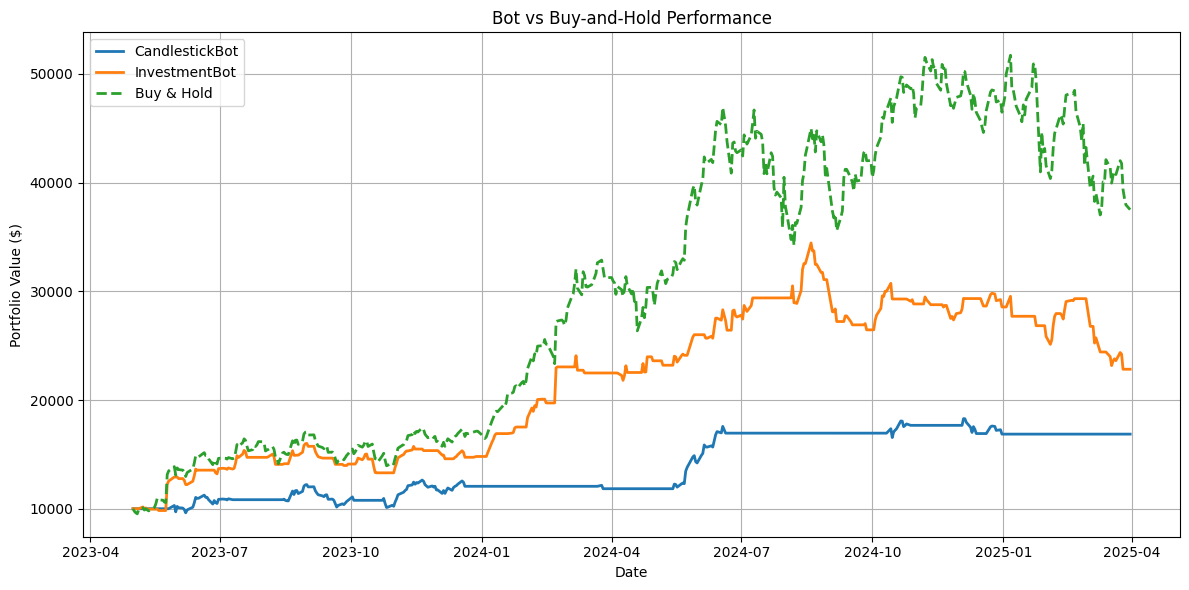

25/04/10 00:22:24 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 303964 ms exceeds timeout 120000 ms
25/04/10 00:22:24 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/10 00:22:28 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [182]:
# Get the same NVDA data the bot used
nvda_data = test_final_df[test_final_df["Ticker"] == "NVDA"].copy()
nvda_data["Date"] = pd.to_datetime(nvda_data["Date"])
nvda_data = nvda_data.set_index("Date").sort_index()

# Only keep dates that the bot used (for fair comparison)
nvda_data = nvda_data[(nvda_data.index.isin(investment_bot_performance.index))]

# Simulate buy-and-hold from the first date
initial_price = nvda_data["Close"].iloc[0]
shares_bought = 10000 / initial_price  # same starting cash
buy_and_hold_value = shares_bought * nvda_data["Close"]

# Plot both
plt.figure(figsize=(12, 6))
plt.plot(candlestick_performance.index, candlestick_performance["Value"], label="CandlestickBot", linewidth=2)
plt.plot(investment_bot_performance.index, investment_bot_performance["Value"], label="InvestmentBot", linewidth=2)
plt.plot(buy_and_hold_value.index, buy_and_hold_value.values, label="Buy & Hold", linestyle="--", linewidth=2)
plt.title("Bot vs Buy-and-Hold Performance")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [175]:
# Set up a grid-search over the number of rules we want to use.
n_rules = np.arange(1, 1000, 10)
metrics = ["confidence", "lift"]

final_portfolio_values = []
colors = []

for n in n_rules:
    for metric in metrics:

        # Generate the buy and sell rules.
        buy_rule = eval(generate_nvda_rule_mask_string(rules_df, direction="NVDA_Up", metric=metric, top_n=n))
        sell_rule = eval(generate_nvda_rule_mask_string(rules_df, direction="NVDA_Down", metric=metric, top_n=n))

        # Instantiate the InvestmentBot.
        investment_bot = InvestmentBot(
            starting_cash=10000, 
            buy_rule=buy_rule,
            sell_rule=sell_rule
        )

        # Get the performance of the bot.
        investment_bot_performance = investment_bot.invest(test_final_df, test_result)

        # Store the final portfolio value.
        final_portfolio_values.append(investment_bot_performance["Value"].iloc[-1])

        if metric == "confidence":
            colors.append("purple")
        else:
            colors.append("orange")

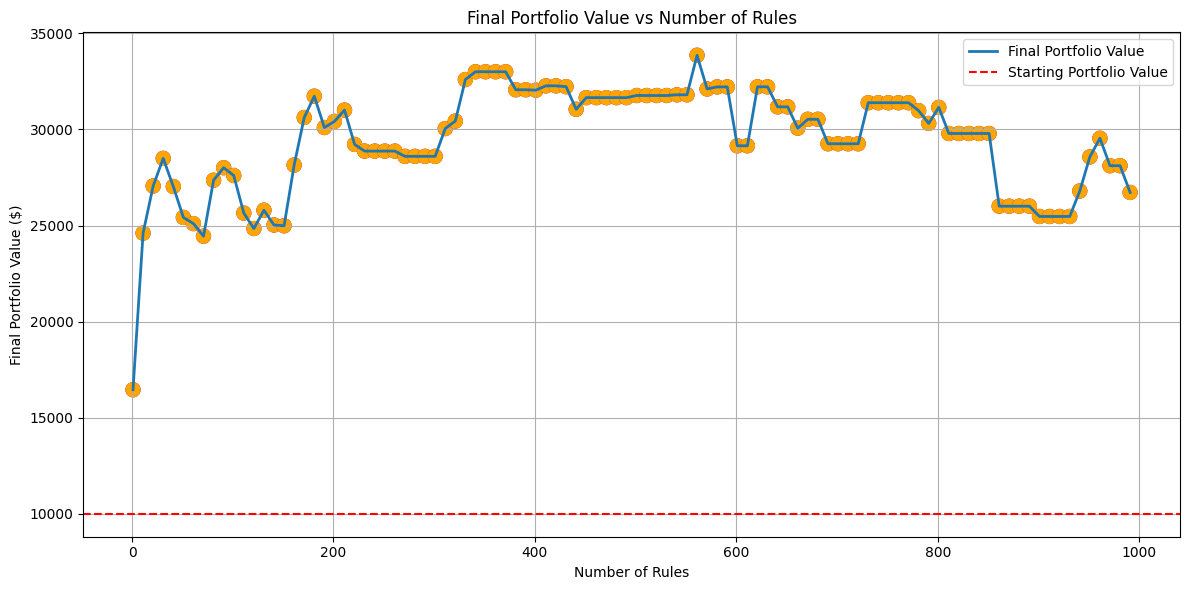

In [176]:
# Plot the final portfolio values.
plt.figure(figsize=(12, 6))
plt.plot(np.repeat(n_rules, len(metrics)), final_portfolio_values, label="Final Portfolio Value", linewidth=2)
plt.scatter(np.repeat(n_rules, len(metrics)), final_portfolio_values, c=colors, s=100, alpha=1)
plt.axhline(y=10000, color="red", linestyle="--", label="Starting Portfolio Value")
plt.title("Final Portfolio Value vs Number of Rules")
plt.xlabel("Number of Rules")
plt.ylabel("Final Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()